In [5]:
"""
This notebook analyses the labelled validation sample of entities to determine:
    - The appropriate confidence score threshold for good entities 
    - The decision to use spaCy post-processing
    - 
"""

'\nThis notebook analyses the labelled validation sample of entities to determine:\n    - The appropriate confidence score threshold for good entities \n    - The decision to use spaCy post-processing\n    - \n'

In [7]:
from nesta_ds_utils.loading_saving.S3 import download_obj
from dap_aria_mapping import BUCKET_NAME

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np

#### 0. Load labelled validation sample

In [8]:
LABELLED_VALIDATION_SAMPLE_PATH = 'inputs/data_collection/entity_evaluation/labelled_entity_validation_sample.csv'
VALIDATION_SAMPLE_CLASSES_PATH = 'inputs/data_collection/entity_evaluation/aria_validation_classes.json'

validation_sample = (download_obj(BUCKET_NAME, LABELLED_VALIDATION_SAMPLE_PATH, 'dataframe')
                     .rename(columns={'spacy_label [0 - entity to keep, 1 - entity to remove]': 'spacy_label'}))     
labelled_validation_sample = (validation_sample
                             .query('~`bad_entity?`.isna()'))       
#add classes 
validation_sample_classes = download_obj(BUCKET_NAME, VALIDATION_SAMPLE_CLASSES_PATH, 'dict')['classes']
validation_sample_classes_clean = {k.replace('dbr:', '').replace('_', ''): [i.replace('dbo:', '') for i in v[1:]] for k, v in validation_sample_classes.items()}
labelled_validation_sample['classes'] = labelled_validation_sample.entity.map(validation_sample_classes_clean)

/var/folders/cq/9gxjkt2j2g1c0cfhjb2qtz000000gn/T/ipykernel_68269/1069108415.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_validation_sample['classes'] = labelled_validation_sample.entity.map(validation_sample_classes_clean)


#### 1. Summary statistics

In [9]:
print(f"{len(labelled_validation_sample)} entities were labelled.")
print(f"{labelled_validation_sample.document_id.nunique()} unique documents were labelled.")

print(f"{labelled_validation_sample.spacy_label.value_counts()[1]} or {labelled_validation_sample.spacy_label.value_counts(normalize=True)[1]*100}% of entities would be removed based on spaCy post-processing.")

print(f"{labelled_validation_sample['bad_entity?'].value_counts(normalize=True)[0]*100}% of entities are entities we want to keep." )
print(f"{labelled_validation_sample['bad_entity?'].value_counts(normalize=True)[1]*100}% of entities are entities we want to remove." )

200 entities were labelled.
56 unique documents were labelled.
34 or 17.0% of entities would be removed based on spaCy post-processing.
75.0% of entities are entities we want to keep.
25.0% of entities are entities we want to remove.


In [10]:
labelled_validation_sample.bad_entity_reason.value_counts()

#entities largely labelled as false positive

false_positive              39
entity_we_want_to_remove     5
low_confidence_score         3
bad_class                    1
Name: bad_entity_reason, dtype: int64

#### 2. Confidence scores

In [11]:
print(f"the average confidence score of bad entities is {labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'yes'].confidence_score.mean()}") 
print(f"the median confidence score of bad entities is {labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'yes'].confidence_score.median()}") 
print('---------')
print(f"the average confidence score of good entities is {labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'no'].confidence_score.mean()}") 
print(f"the median confidence score of good entities is {labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'no'].confidence_score.median()}") 



the average confidence score of bad entities is 61.2
the median confidence score of bad entities is 60.0
---------
the average confidence score of good entities is 74.0
the median confidence score of good entities is 70.0


<AxesSubplot: title={'center': 'Distribution of confidence scores for "bad" entities'}, ylabel='Frequency'>

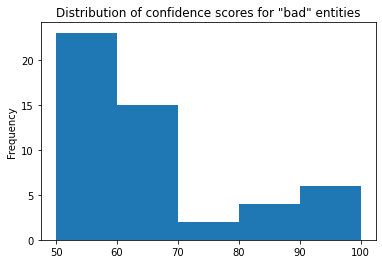

In [12]:
labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'yes'].confidence_score.plot(kind='hist', bins=5, title='Distribution of confidence scores for "bad" entities')

<AxesSubplot: title={'center': 'Distribution of confidence scores for "good" entities'}, ylabel='Frequency'>

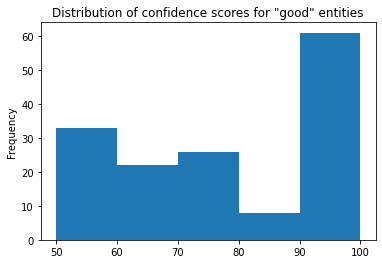

In [13]:
labelled_validation_sample[labelled_validation_sample['bad_entity?'] == 'no'].confidence_score.plot(kind='hist', bins=5, title='Distribution of confidence scores for "good" entities')

In [14]:
confidence_thresholds = [60, 70, 80, 90]
for thresh in confidence_thresholds:
    ent_percent_removed = len(validation_sample.query(f"confidence_score <= {thresh}"))/len(validation_sample)
    good_ent_percent = len(labelled_validation_sample[(labelled_validation_sample['bad_entity?'] == 'no') & (labelled_validation_sample['confidence_score'] >= thresh)])/len(labelled_validation_sample.query(f"confidence_score >= {thresh}"))
    print(f"At confidence threshold {thresh}, {ent_percent_removed*100}% of entities would be removed")
    print(f"At confidence threshold {thresh}, {good_ent_percent*100}% of entities are labelled 'good'")
    print('---')

# looks like confidence scores go in multiples of 10 - I reckon 70 or 80 is optimal   

At confidence threshold 60, 43.34975369458128% of entities would be removed
At confidence threshold 60, 81.25% of entities are labelled 'good'
---
At confidence threshold 70, 57.389162561576356% of entities would be removed
At confidence threshold 70, 88.78504672897196% of entities are labelled 'good'
---
At confidence threshold 80, 65.02463054187191% of entities would be removed
At confidence threshold 80, 87.34177215189874% of entities are labelled 'good'
---
At confidence threshold 90, 88.66995073891626% of entities would be removed
At confidence threshold 90, 91.04477611940298% of entities are labelled 'good'
---


In [15]:
len(labelled_validation_sample[(labelled_validation_sample['bad_entity?'] == 'no') & (labelled_validation_sample['confidence_score'] >= 60)])/len(validation_sample.query(f"confidence_score <= {60}"))

0.6647727272727273

#### 3. spaCy post-processing performance

In [16]:
print(f"{len(labelled_validation_sample[(labelled_validation_sample['bad_spacy_label?'] == 'yes') & (labelled_validation_sample['spacy_label'] == 1)])/len(labelled_validation_sample[labelled_validation_sample['spacy_label'] == 1])}% of entities that would be post-processed are incorrectly labelled")

0.7647058823529411% of entities that would be post-processed are incorrectly labelled


In [17]:
def convert_bad_spacy_label(spacy_label, bad_spacy_label):
    if bad_spacy_label == 'yes':
        if spacy_label == 1:
            return 0
        else:
            return 1
    else:
        return spacy_label

In [18]:
y_pred = labelled_validation_sample.spacy_label
y_true = labelled_validation_sample.apply(lambda x: convert_bad_spacy_label(x['spacy_label'], x['bad_spacy_label?']), axis=1)

In [19]:
scores = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        }

print(scores)

{'accuracy': 0.86, 'precision': 0.23529411764705882, 'recall': 0.8, 'f1': 0.3636363636363636}


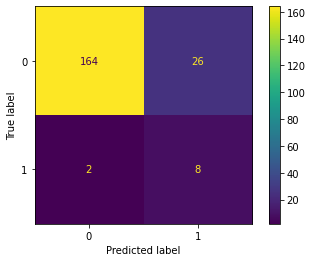

In [20]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# precision is VERY low - did well with companies house data for AI genomics but the incidence of extracting
# people, money and company names in patent abstracts is very low - I'd hazard the same for publication abstracts  

#### 4. Entity classes

In [21]:
labelled_validation_sample['classes'] = labelled_validation_sample.classes.apply(lambda x: np.nan if x == [] else x)

/var/folders/cq/9gxjkt2j2g1c0cfhjb2qtz000000gn/T/ipykernel_68269/2448997566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_validation_sample['classes'] = labelled_validation_sample.classes.apply(lambda x: np.nan if x == [] else x)


In [22]:
labelled_validation_sample.classes.isna().value_counts() 

True     184
False     16
Name: classes, dtype: int64

In [23]:
 labelled_validation_sample[(~labelled_validation_sample['classes'].isna()) & (labelled_validation_sample['bad_entity?'] == 'yes')]

,abstract,data_source,row_number,document_id,entity,confidence_score,spacy_label,bad_entity?,bad_entity_reason,bad_spacy_label?,notes,classes
223,An exhaust gas turbocharger coupling assembly ...,patents,58,US-9677473-B2,Lip,70,0,yes,NaN,no,not enough context - if its just a lip then wr...,[AnatomicalStructure]
